In [ ]:
'''Portfolio construction with 3 common method: 
                                'Equally Weighted Portfolio', 
                                'Minimum Variance Portfolio', 
                                'Maximum Sharpe Ratio Portfolio' 
                                using cplex'''

# Setup

In [ ]:
pip install yfinance

In [ ]:
pip install cplex

In [4]:
import pandas as pd
import numpy as np
import cplex
import math
import matplotlib.pyplot as plt

# Methods

In [5]:
def trade_towards_target(x_init, cash_init, cur_prices,x_optimal,total_value):
    converged = False
    weight_of_buy = [0] * n
    weight_of_sell = [0] * n
    adjust_value  = [0] * n 
    x_adjust = [0] * n
    total_buy = 0
    total_sell = 0
    while not converged:
        change = [(x_optimal[i] - x_init[i]) for i in range(n)]   # change num of shares
        for i in range(n):
            if change[i] > 0:
                total_buy += change[i] * cur_prices[i]
            elif change[i] < 0:
                total_sell += change[i] * cur_prices[i]        
         
        trade =  [abs(x_optimal[i] - x_init[i]) for i in range(n)]   #num of shares trade for each asset: abs since transction cost regardless sell or buy
        trade_value = np.dot(cur_prices, trade)
        
        new_port_value = np.dot(x_optimal,cur_prices) 

        difference =  tc * trade_value + new_port_value  - total_value  #- cash_init
        if difference > 0:
            for i in range(n):
                if change[i] > 0:
                    weight_of_buy[i] = change[i] * cur_prices[i] / total_buy    # buy less amount to cover the transction cost
                    adjust_value[i] = difference * weight_of_buy[i]
                    x_adjust[i] = (adjust_value[i] / cur_prices[i])   
                if x_optimal[i] > x_adjust[i]:
                    x_optimal[i] =  x_optimal[i] - x_adjust[i]                #new num of assets/share. 
        
        x_optimal = np.floor(x_optimal) 
        final_value = np.dot(x_optimal,cur_prices)                    #new port value after all trades
        final_trade_shares = [abs(x_optimal[i] - x_init[i]) for i in range(n)]  #adjusted num of shares traded
        final_trade_value = np.dot(final_trade_shares,cur_prices) 
        cash_optimal = total_value - final_value - final_trade_value * tc
    
        if cash_optimal > 0:            #sell less
            for i in range(n):
                if change[i] < 0:
                    weight_of_sell[i] = change[i] * cur_prices[i] / total_sell    # sell less amount to cover extra cash
                    adjust_value[i] = cash_optimal * weight_of_sell[i]
                    x_adjust[i] = (adjust_value[i] / cur_prices[i])         
                    x_optimal[i] =  x_optimal[i] + x_adjust[i]

        x_optimal = np.floor(x_optimal) 
        final_value = np.dot(x_optimal,cur_prices)                    #new port value after all trades
        final_trade_shares = [abs(x_optimal[i] - x_init[i]) for i in range(n)]  #adjusted num of shares traded
        final_trade_value = np.dot(final_trade_shares,cur_prices) 
        cash_optimal = total_value - final_value - final_trade_value * tc
    
        if 0 < cash_optimal:
            converged = True
        
    print('Cash : ',cash_optimal)
    
    return x_optimal , cash_optimal , final_trade_value

In [6]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
  x_optimal = [0 for i in range(n)]
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)
  total_money = np.dot(cur_prices, x_init)
  current_weight = [(x_init[i] * cur_prices[i])/total_money for i in range(n)]
  c = [0.0] * n
  lb = [0.0] * n
  ub = [1.0] * n

  A = []
  for k in range(n):
    A.append([[0],[1.0]])

  total_asset = np.dot(cur_prices, x_init)
  cpx.linear_constraints.add(rhs=[1.0], senses = 'E')
  var_names = ["weight_%s" % i for i in range(1, n+1)]

  cpx.variables.add(obj=c, lb=lb, ub=ub, columns = A, names =  var_names)
  Qmat = [[list(range(n)), list(2*Q[i,:])] for i in range(n)]
  cpx.objective.set_quadratic(Qmat)

  alg = cpx.parameters.lpmethod.values
  alg = cpx.parameters.qpmethod.set(alg.concurrent)
  
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  cpx.solve()
  numrows = cpx.solution.get_values()
  for i in range(n):
    x_optimal[i] = np.reshape(numrows, (1,-1))[0][i] * total_money / cur_prices[i]
  x_optimal, cash_optimal, final_trade_value = trade_towards_target(x_init, cash_init, cur_prices, x_optimal, total_money)

  return x_optimal, cash_optimal, final_trade_value

In [1]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):      
    n = 21
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    #c  = current_weight
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [cplex.infinity] * n

    A = []
    for k in range(n-1):
        A.append([[0,1],[(mu[k]*252 - r_rf),1.0]])
    A.append([[0,1],[0,-1.0]])
    zero1 = np.zeros((20,1))
    Q_sharpe = np.append(Q, zero1, axis=1)
    zero2 = np.zeros((1,21))
    Q_sharpe = np.append(Q_sharpe, zero2, axis=0)
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)

    Qmat = [[list(range(n)), list(2*Q_sharpe[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    y_k = np.array(cpx.solution.get_values())
    weight = np.array([(y_k[i]/y_k[20]) for i in range(20)])
    total_value = np.dot(x_init,cur_prices) + cash_init
    x_optimal = [0] * 20
    for i in range(20):
        x_optimal[i] = weight[i] * total_value / cur_prices[i] 
    x_optimal , cash_optimal, final_trade_value = trade_towards_target(x_init, cash_init, cur_prices, x_optimal,total_value)
   
    return x_optimal, cash_optimal, final_trade_value

In [7]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    final_trade_value = 0
    
    return x_optimal, cash_optimal, final_trade_value

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = [0] * n
    total_value = np.dot(cur_prices , x_init) + cash_init  #total value / 20
    value = total_value / n
    for i in range(n):
      x_optimal[i] = value / cur_prices[i]
    x_optimal , cash_optimal, final_trade_value = trade_towards_target(x_init, cash_init, cur_prices, x_optimal, total_value)  
    
    return x_optimal, cash_optimal, final_trade_value

# Main Loop

In [22]:
tc = 0.005     #trade_cost 0.5%
n = 20 
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2018 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2019-2020 is 2.5%
r_rf = 0.025

strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]
 
N_strat = len(strategy_functions)  

#store values
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
w = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
final_trade_value = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 19:
       cur_year  = 19 + math.floor(period/7)
   else:
       cur_year  = 2019 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] , final_trade_value[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      w[strategy, period-1] =  x[strategy, period-1] * cur_prices / np.dot(x[strategy, period-1],cur_prices)
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Refer to trade_towards_target ############################
      
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000070.06


Period 1: start date 01/02/2019, end date 02/28/2019
  Strategy "Buy and Hold", value begin = $ 1000070.06, value end = $ 1121179.83
Cash :  72.93570102453123
  Strategy "Equally Weighted Portfolio", value begin = $ 991124.11, value end = $ 1097321.88
Cash :  8.621607835291798
  Strategy "Minimum Variance Portfolio", value begin = $ 991711.94, value end = $ 1057916.51
Cash :  11.250946712492805
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990119.61, value end = $ 1016529.60

Period 2: start date 03/01/2019, end date 04/30/2019
  Strategy "Buy and Hold", value begin = $ 1126131.27, value end = $ 1075001.89
Cash :  248.2284946703445
  Strategy "Equally Weighted Portfolio", value begin = $ 1103608.73, value end = $ 1189149.57
Cash :  128.7986228704449
  Strategy "Minimum Variance Portfolio", value begin = $ 1055883.79, value end = $ 1108334.95
Cash :  2.6772027539736882
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1

# Visualization and Discussion

Text(0, 0.5, '% increase')

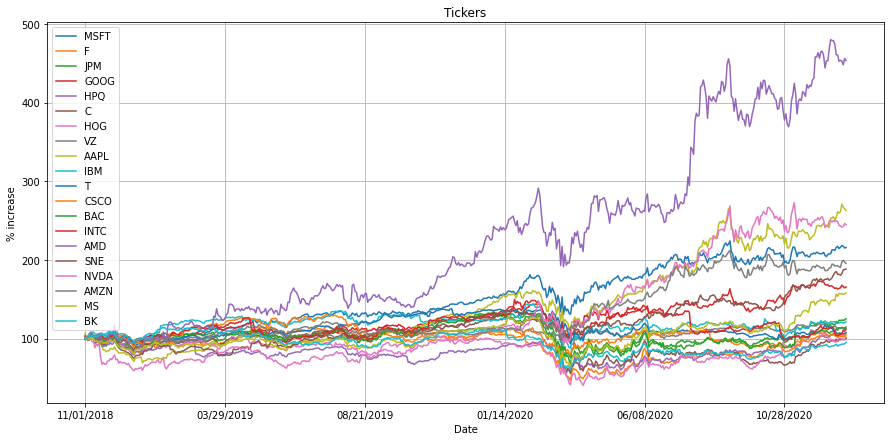

In [10]:
tickers = 100 * df[df.columns[1:]] / df[df.columns[1:]].iloc[1]
tickers = tickers.set_index(df.iloc(axis=1)[0])
tickers.plot(figsize= [15,7], grid = True, title = 'Tickers')

plt.ylabel('% increase')

In [11]:
import yfinance as yf
spy = yf.download(['SPY'],start='2018-11-01', end='2020-12-31')

[*********************100%***********************]  1 of 1 completed


In [12]:
chart0 = pd.DataFrame(portf_value[0],columns = ['Buy and Hold'])
chart1 = pd.DataFrame(portf_value[1],columns = ['Equally Weighted Portfolio'])
chart2 = pd.DataFrame(portf_value[2],columns = ['Minimum Variance Portfolio'])
chart3 = pd.DataFrame(portf_value[3],columns = ['Maximum Sharpe Ratio Portfolio'])
chart = pd.concat([chart0,chart1,chart2,chart3],axis=1)
chart.set_index(df['Date'].iloc[40:],inplace = True)
chart['SP500'] = spy['Adj Close'].iloc[39:].values  * init_value / spy['Adj Close'].iloc[39]
chart

,Buy and Hold,Equally Weighted Portfolio,Minimum Variance Portfolio,Maximum Sharpe Ratio Portfolio,SP500
Date,,,,,
01/02/2019,1.000070e+06,9.911241e+05,9.917119e+05,9.901196e+05,1.000070e+06
01/03/2019,9.802613e+05,9.589846e+05,9.841390e+05,9.936534e+05,1.001110e+06
01/04/2019,1.009693e+06,1.002367e+06,1.003533e+06,9.961291e+05,9.772211e+05
01/07/2019,1.008352e+06,1.017564e+06,1.012935e+06,1.002491e+06,1.009954e+06
01/08/2019,1.006443e+06,1.024292e+06,1.029712e+06,1.031829e+06,1.017917e+06
...,...,...,...,...,...
12/24/2020,9.429962e+05,1.664082e+06,1.258245e+06,2.464617e+06,1.526694e+06
12/28/2020,9.511236e+05,1.676028e+06,1.262707e+06,2.479502e+06,1.532633e+06
12/29/2020,9.501240e+05,1.674004e+06,1.269571e+06,2.488936e+06,1.545800e+06


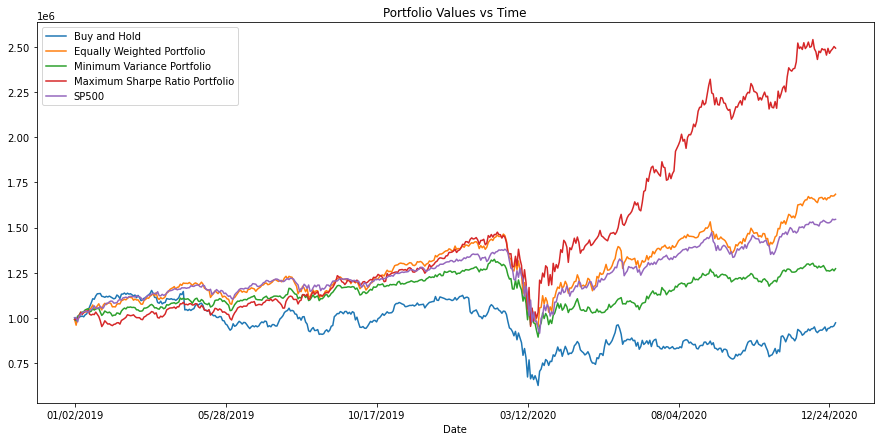

In [13]:
chart.plot(figsize=[15,7],title='Portfolio Values vs Time')

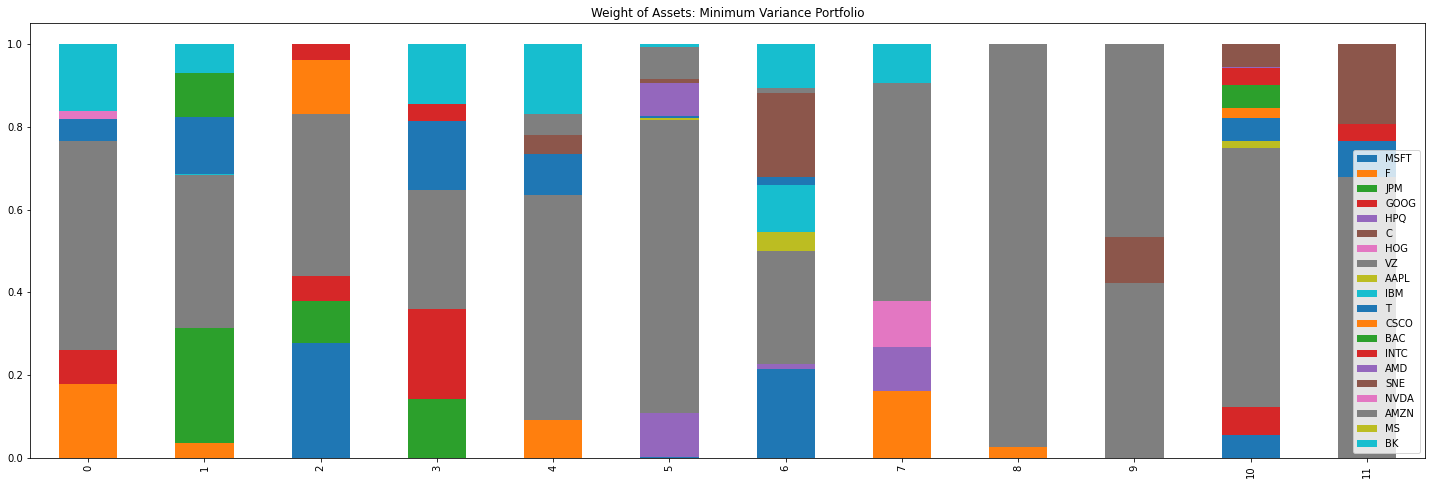

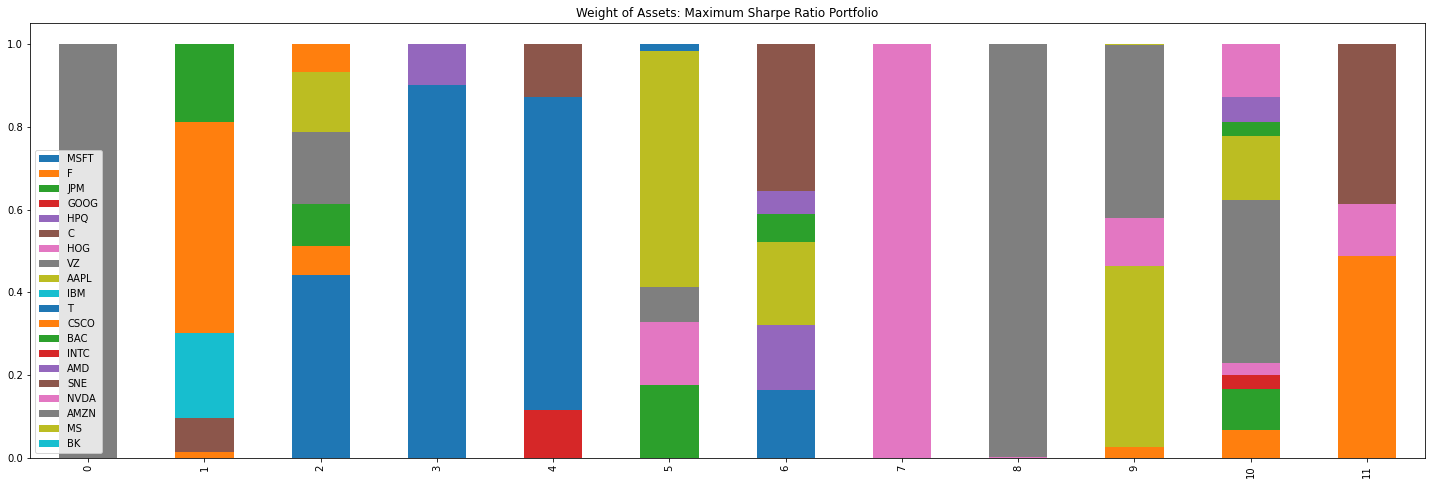

In [14]:
# bar plots
s0 = pd.DataFrame(w[0],columns = ['S'])
s1 = pd.DataFrame(w[1],columns = ['S'])
s2 = pd.DataFrame(w[2],columns = ['S'])
s3 = pd.DataFrame(w[3],columns = ['S'])

w0 = pd.DataFrame()
w1 = pd.DataFrame()
w2 = pd.DataFrame()
w3 = pd.DataFrame()

w0[df.columns[1:]] = pd.DataFrame(s0.S.tolist())
w1[df.columns[1:]] = pd.DataFrame(s1.S.tolist())
w2[df.columns[1:]] = pd.DataFrame(s2.S.tolist())
w3[df.columns[1:]] = pd.DataFrame(s3.S.tolist())

# w0.plot.bar(figsize =[25,8], stacked=True, title = 'Weight of Assets: Buy and Hold')
# w1.plot.bar(figsize =[25,8], stacked=True, title = 'Weight of Assets: Equally Weighted Portfolio')
w2.plot.bar(figsize =[25,8], stacked=True, title = 'Weight of Assets: Minimum Variance Portfolio')
w3.plot.bar(figsize =[25,8], stacked=True, title = 'Weight of Assets: Maximum Sharpe Ratio Portfolio')


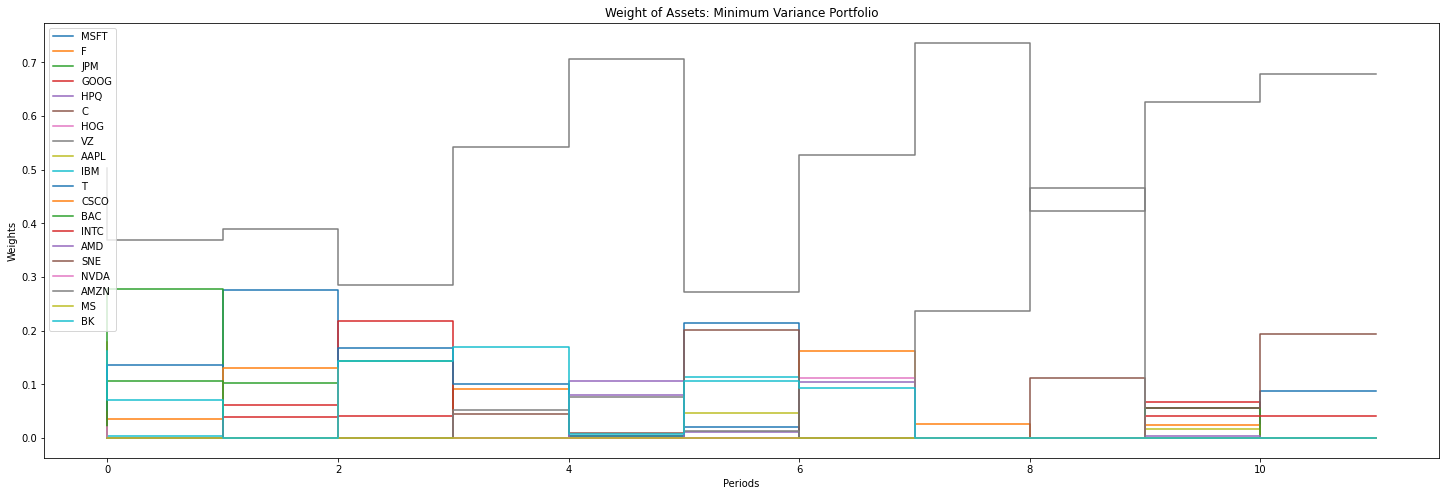

In [15]:
plt.figure(figsize = [25,8])
plt.title('Weight of Assets: Minimum Variance Portfolio')
plt.ylabel('Weights')
plt.xlabel('Periods')
plt.step(w2.index, w2.iloc(axis=1)[:])
plt.legend(w2.columns, loc = 'upper left')

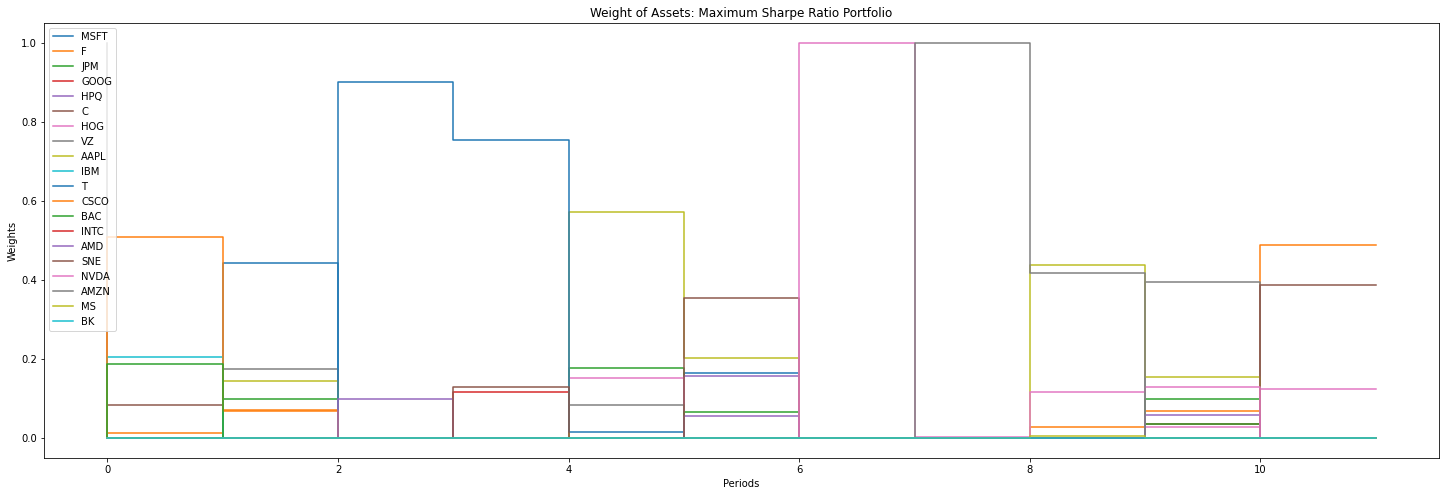

In [16]:
plt.figure(figsize = [25,8])
plt.title('Weight of Assets: Maximum Sharpe Ratio Portfolio')
plt.ylabel('Weights')
plt.xlabel('Periods')
plt.step(w3.index, w3.iloc(axis=1)[:])
plt.legend(w2.columns, loc = 'upper left')

*Discussion*

In [17]:
# Hold '1/n' weight for each assets
print(init_value)
init_prices = df.iloc[40][1:]
x_optimal = [0] * n 
value = init_value / n
for i in range(n):
  x_optimal[i] = round(value / init_prices[i],0) 
x_optimal , cash_optimal , f_trade_value= trade_towards_target(init_positions, 0, init_prices,x_optimal,init_value)
result = [np.dot(x_optimal,df[df.columns[1:]].iloc[i]) for i in range(40,545)]

1000070.0553894043
Cash :  73.79635423660329


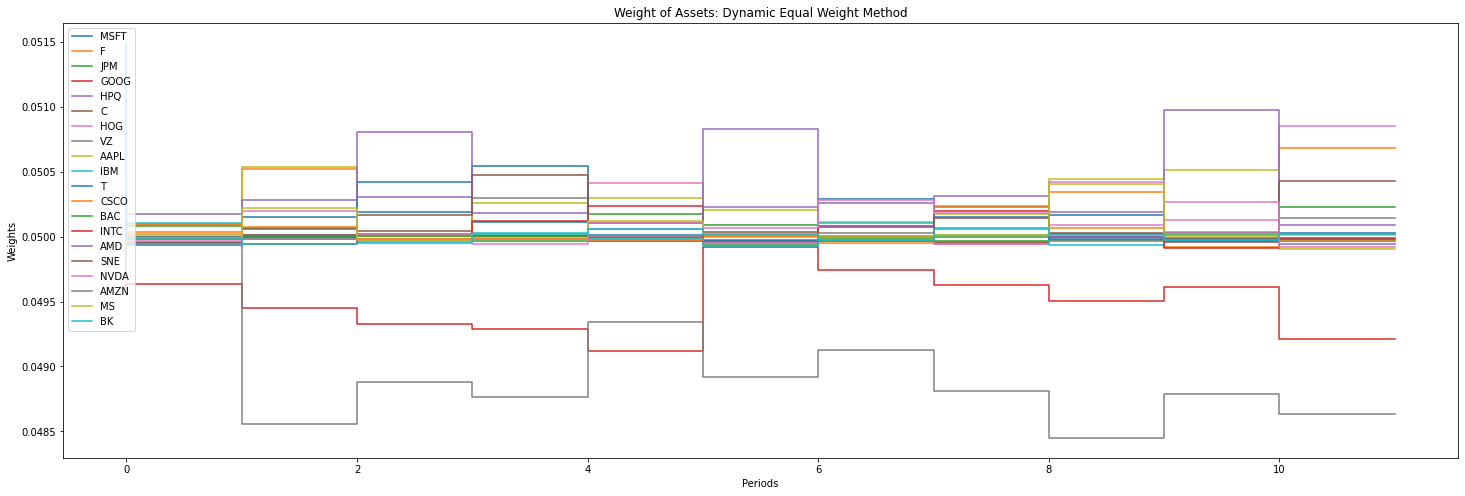

In [18]:
plt.figure(figsize = [25,8])
plt.title('Weight of Assets: Dynamic Equal Weight Method')
plt.ylabel('Weights')
plt.xlabel('Periods')
# plt.ylim(0,0.1)
plt.step(w1.index, w1.iloc(axis=1)[:])
plt.legend(w2.columns, loc = 'upper left')

Text(0.5, 1.0, 'Hold Vs. Rebalance Every 2 Months and SP500')

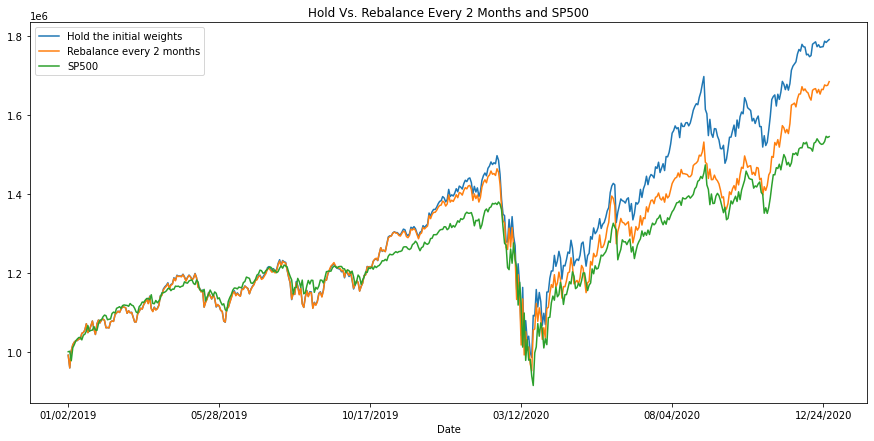

In [19]:
plt.figure(figsize=[15,7])
plt.plot(result)
chart['Equally Weighted Portfolio'].plot()
chart['SP500'].plot()
plt.legend(['Hold the initial weights','Rebalance every 2 months','SP500'])
plt.title('Hold Vs. Rebalance Every 2 Months and SP500')

1. As the trading cost is high, holding the initial portfolio generates a much better outcome. Also, we are lucky that the initial bet of the assets beats the market.

2. As shown in the "ticker" figure, new tech companies like "AMD" and "AMZN" soars up during the period while the prices of the manufacturing  businesses like "F" and "HOG" hardly change. In such market, frequently adjust weights would waste the growing potential of the booming companies. Adjusting weight is considered to be more conservative.

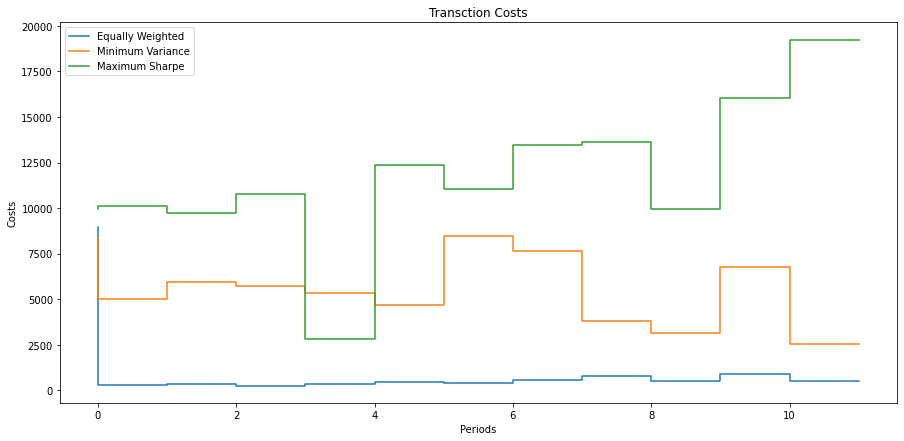

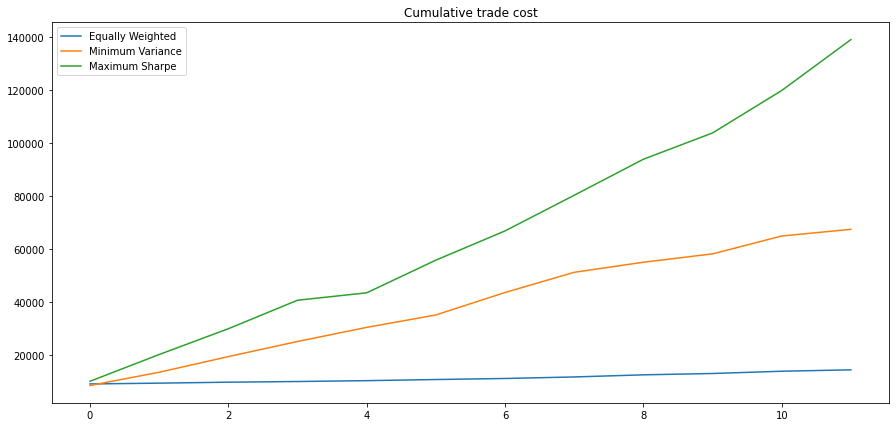

In [20]:
traded = pd.DataFrame(tc * final_trade_value[1:]).T
traded.columns =['Equally Weighted','Minimum Variance','Maximum Sharpe']

plt.figure(figsize = [15,7])
plt.title('Transction Costs')
plt.ylabel('Costs')
plt.xlabel('Periods')
plt.step(traded.index, traded.iloc(axis=1)[:])
plt.legend(['Equally Weighted','Minimum Variance','Maximum Sharpe'], loc = 'upper left')

traded.cumsum().plot(figsize = [15,7], title = 'Cumulative trade cost')

As shown above, the Maximum Sharpe method incur the most transction cost: 140,000 dollars, 14% of the initial portfolio. As a return, it generate the most profit: Nearly 1.5M. It is worth to take this method. 

Besides, the equal weight method have negligible transction cost, since the stocks have postive correlations, and thus no drastic trades.

Improvement

When accounting the total profits, the strategies does not count for the dividend payments, which are significant for value stocks. For example, the minimum variance method may have more profits since the values stocks pay more dividends while having low variances thus perferred by the minimum variance method.

Therefore, one improvement could include the dividend payments as extra return or cash.
